In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

## 1. System Model

In [2]:
## i -> The i-th window
## j -> The relative offset with the j-th window

T_GCL = None
GRANULARITY = 1_000
T_Pm = {}
## Number of window cases
N_Pm = {}

In [3]:
## t_Pm_o_i[Pm][i]
t_Pm_o_i = {}
t_Pm_c_i = {}

In [4]:
l_max_Pm = {}
l_min_Pm = {}

In [5]:
l_tt = {}
p_tt = {}

In [6]:
tt_Pm = {}
Pm_tt = {}

In [7]:
def h(a, b, Pm):
    max_d = -1
    for s in range(0, T_GCL, GRANULARITY):
        if a(s, Pm) >= b(s, Pm):
            for d in range(0, T_GCL - s, GRANULARITY):
                if b(s + d, Pm) >= a(s, Pm):
                    if d > max_d:
                        max_d = d
                    break
    return max_d

## 2. Service curve

$$\beta_{T, L}(t)=C \cdot \max \left(\left\lfloor\frac{t}{T}\right\rfloor L, t-\left\lceil\frac{t}{T}\right\rceil(T-L)\right)$$

In [8]:
## T = Period
## L = Window length

def TDMA_service(t, T, L):
    return max(np.floor(t / T) * L, t - np.ceil(t / T)*(T - L))

$$\beta_{P_{m}}^{j, i}(t)=\beta_{T_{G C L}, \bar{L}_{P_{m}}^{j}}\left(t+T_{G C L}-\bar{L}_{P_{m}}^{j}-S_{P_{m}}^{i}-o_{P_{m}}^{j, i}\right)$$

In [9]:
## P_m: critical traffic priority
def beta_i_j_Pm(t, Pm, i, j):
    return TDMA_service(t + T_GCL - L_Pm_i(Pm, j) - S_Pm_i(Pm, i) - o_Pm_i_j(Pm, i, j), T_GCL, L_Pm_i(Pm, j))

$$\beta_{P_{m}}^{i}(t)=\sum_{j=i}^{i+N_{P_{m}}-1} \beta_{P_{m}}^{j, i}(t)$$

In [10]:
def beta_i_Pm(t, Pm, i):
    result = 0
    for j in range(i, i + N_Pm[Pm]):
        result += beta_i_j_Pm(t, Pm, i, j)
    return result

In [11]:
def beta_Pm(t, Pm):
    return min([beta_i_Pm(t, Pm, i+1) for i in range(N_Pm[Pm])])

## 3. GUARANTEED TIME SLOT

Analysis for $L_{Pm}^i$

In [12]:
def G_PmPos(PmPos, t):
    global GCL
    for row in [x for x in GCL if x[-1] == PmPos]:
        if row[0] < t < row[1]:
            return 1
    return 0
    
def G_PmNeg(PmPos, t):
    global GCL
    for row in [x for x in GCL if x[-1] == PmPos]:
        if row[0] < t < row[1]:
            return 1
    return 0

### 3.1 Collision from Lower priority

$$t_{P_{m}}^{c, i}=\inf _{t \geq t_{P_{m}}^{o, i}}\left\{G_{P_{m^{+}}}(t)=0\right\}$$

In [13]:
## input is Pm
def t_PmPos_c_i(Pm, PmPos, i):
    result = t_Pm_o_i[Pm][i]
    while result <= T_GCL:
        if G_PmPos(PmPos, result) == 0:
            return result
        result += GRANULARITY

$$d_{P_{m^{+}}}^{n p, i}= \begin{cases}\min \left\{\frac{l_{P_{m^{+}}}^{\max }}{C}, t_{P_{m^{+}}, i}^{c, i}-t_{P_{m}}^{o, i}\right\}, & G_{P_{m^{+}}}\left(t_{P_{m}}^{o, i}\right)=1 \\ 0 & G_{P_{m^{+}}}\left(t_{P_{m}}^{o, i}\right)=0,\end{cases}$$

In [14]:
def d_PmPos_np_i(PmPos, Pm, i):
    if G_PmPos(PmPos, t_Pm_o_i[Pm][i]) == 0:
        return 0
    else:
        return min(l_max_Pm[PmPos], t_PmPos_c_i(Pm, PmPos, i) - t_Pm_o_i[Pm][i])

$$d_{L}^{n p, i}=\max _{m+1 \leq m^{+} \leq n}\left\{d_{P_{m^{+}}^{n p, i}}\right\}$$

In [15]:
def d_L_np_i(Pm, i):
    return max([d_PmPos_np_i(pmPos, Pm, i) for pmPos in range(Pm+1, 8+1) if pmPos in t_Pm_o_i])

$$t_{L}^{n p, i}=d_{L}^{n p, i}+t_{P_{m}}^{o, i}$$

In [16]:
## t_L_np_i -> start time of guaranteed time slot.
def t_L_np_i(Pm, i):
    return d_L_np_i(Pm, i) + t_Pm_o_i[Pm][i]

### 3.2 Effect of the look head

$$t_{P_{m}}^{g b, i}=t_{P_{m}}^{c, i}-d_{P_{m}}^{g b}$$

$$d_{P_{m}}^{g b}=\frac{l_{P_{m}}^{\max }}{C}$$

In [17]:
def t_Pm_gb_i(Pm, i):
    return t_Pm_c_i[Pm][i] - l_max_Pm[Pm]

### 3.3 Collision from Higher priority

$$t_{P_{m^{-}}}^{c, i}=\inf _{t \geq t_{P_{m}}^{o, i}}\left\{G_{m^{-}}(t)=0\right\}$$

In [18]:
## Input is Pm
def t_PmNeg_c_i(Pm, PmNeg, i):
    result = t_Pm_o_i[Pm][i]
    while result <= T_GCL:
        if G_PmNeg(PmNeg, result) == 0:
            return result
        result += GRANULARITY

$$t_{P_{m^{-}}^{o, i}}^{o}=\sup _{t \leq t_{P_{m}}^{c, i}}\left\{G_{P_{m^{-}}}(t)=0\right\}$$

In [19]:
## Input is Pm
def t_PmNeg_o_i(Pm, PmNeg, i):
    result = t_Pm_c_i[Pm][i]
    while result >= 0:
        if G_PmNeg(PmNeg, result) == 0:
            return result
        result -= GRANULARITY

$$t_{H}^{B, i}=\underset{1 \leq m^{-} \leq m-1}{\max }\left\{t_{P_{m^{-}}^{c, i}}\right\}$$

In [20]:
def t_H_B_i(Pm, i):
    if Pm == 1:
        return t_Pm_o_i[Pm][i]
    return max([t_PmNeg_c_i(Pm, PmNeg, i) for PmNeg in range(1, Pm)])

$$t_{H}^{E, i}=\min _{1 \leq m^{-} \leq m-1}\left\{t_{P_{m^{-}}}^{o, i}\right\}$$

In [21]:
def t_H_E_i(Pm, i):
    if Pm == 1:
        return t_Pm_c_i[Pm][i]
    return max([t_PmNeg_o_i(Pm, PmNeg, i) for PmNeg in range(1, Pm)])

### 3.4 Comprehensive effect considerations

$$t_{P_{m}}^{B, i}=\max \left\{t_{L}^{n p, i}, t_{H}^{B, i}\right\}$$

In [22]:
def t_Pm_B_i(Pm, i):
    return max(t_L_np_i(Pm, i), t_H_B_i(Pm, i))

$$t_{P_{m}}^{E, i}=\min \left\{t_{P_{m}}^{g b, i}, t_{H}^{E, i}\right\}$$

In [23]:
def t_Pm_E_i(Pm, i):
    if i == 0:
        return 0
    return min(t_Pm_gb_i(Pm, i), t_H_E_i(Pm, i))

$$\bar{L}_{P_{m}}^{i}= \begin{cases}\max \left\{t_{P_{m}}^{E, i}-t_{P_{m}}^{B, i}, \frac{l_{P_{m}}^{\min }}{C}\right\}, & t_{P_{m}}^{B, i}<t_{P_{m}}^{E, i} \\ 0 & t_{P_{m}}^{B, i} \geq t_{P_{m}}^{E, i}\end{cases}$$

In [24]:
def L_Pm_i(Pm, i):
    if t_Pm_B_i(Pm, i) >= t_Pm_E_i(Pm, i):
        return 0
    else:
        return max(t_Pm_E_i(Pm, i) - t_Pm_B_i(Pm, i), l_min_Pm[Pm])

$$\bar{o}_{P_{m}}^{i}=t_{P_{m}}^{B, i}-\left.t_{P_{m}}^{o, i}\right|_{\bar{L}_{P_{m}}^{i} \neq 0}$$

In [25]:
def o_Pm_i(Pm, i):
    if L_Pm_i(Pm, i) == 0:
        assert()
    return t_Pm_B_i(Pm, i) - t_Pm_E_i(Pm, i)

$$o_{P_{m}}^{j, i}=(j-i) \cdot T_{P_{m}}-\bar{o}_{P_{m}}^{i}+\bar{o}_{P_{m}}^{j}$$

In [26]:
def o_Pm_i_j(Pm, i, j):
    return (j - i) * T_Pm[Pm] - o_Pm_i(Pm, i) + o_Pm_i(Pm, j)

## 4. Maximum waiting time

$$t_{P_{m^{+}}^{o, i-1}} = {\sup _{t \leq t_{P_{m}}^{E, i-1}}}\left\{G_{P_{m^{+}}}(t)=0\right\}$$

In [27]:
## Input is Pm
def t_PmPos_o_i(Pm, PmPos, i):
    result = t_Pm_E_i(Pm, i)
    while result >= 0:
        if G_PmPos(PmPos, result) == 0:
            return result
        result -= GRANULARITY

$$d_{L}^{n p, 0}=\max _{m+1 \leq m^{+} \leq n}\left\{\min \left\{\frac{l_{P_{m^{+}}}^{\max }}{C}, t_{P_{m}^{E,i-1}}-t_{P_{m^{+}}}^{o}\right\}\right\}$$

In [28]:
def d_L_np_0(Pm, i):
    result = 0
    if i == 0:
        return 0
    for PmPos in [x for x in l_max_Pm.keys() if x > Pm]:
        temp = min(l_max_Pm[PmPos], t_Pm_E_i(Pm, i-1) - t_PmPos_o_i(Pm, PmPos, i-1))
        if temp > result:
            result = temp
    return result

$$S_{P_{m}}^{i}=d_{L}^{n p, 0}+t_{P_{m}}^{B, i}-t_{P_{m}}^{E, i-1}$$

In [29]:
def S_Pm_i(Pm, i):
    return d_L_np_0(Pm, i) + t_Pm_B_i(Pm, i) - t_Pm_E_i(Pm, i-1)

## 5. WCRT

In [30]:
def alpha_tt(t, tt):
    return max((l_tt[tt] / p_tt[tt]) * t + l_tt[tt], 0)

In [31]:
def alpha_Pm(t, Pm):
    return sum([alpha_tt(t, tt) for tt in Pm_tt[Pm]])

# Testing Case

In [32]:
GCL = [(70_000, 90_000, 7), (85_000, 105_000, 5), (40_000, 60_000, 3), (95_000, 115_000, 2), (55_000, 75_000, 1)]

In [33]:
tt_Pm[1] = 2
Pm_tt[2] = [1]
l_tt[1] = 3200
p_tt[1] = 250_000

In [34]:
## Number of window cases:

for row in GCL:
    Pm = row[-1]
    N_Pm[Pm] = 1
    T_Pm[Pm] = 250_000
    T_GCL = 250_000
    t_Pm_o_i.setdefault(Pm, {})
    t_Pm_c_i.setdefault(Pm, {})
    t_Pm_o_i[Pm][0]= 0
    t_Pm_c_i[Pm][0]= 0
    for i in range(N_Pm[Pm]):
        t_Pm_o_i[Pm][i+1]= row[0] + i * T_Pm[Pm]
        t_Pm_c_i[Pm][i+1]= row[1] + i * T_Pm[Pm]
    if Pm in Pm_tt:
        l_max_Pm[Pm] = max([l_tt[tt] for tt in Pm_tt[Pm]])
        l_min_Pm[Pm] = min([l_tt[tt] for tt in Pm_tt[Pm]])
    else:
        l_max_Pm[Pm] = 0
        l_min_Pm[Pm] = 0

### Hop 1

In [35]:
GCL = [(70_000, 90_000, 7), (85_000, 105_000, 5), (40_000, 60_000, 3), (95_000, 115_000, 2), (55_000, 75_000, 1)]

In [36]:
tt_Pm[1] = 2
Pm_tt[2] = [1]
l_tt[1] = 3200
p_tt[1] = 250_000

In [37]:
## Number of window cases:
T_GCL = 250_000
for row in GCL:
    Pm = row[-1]
    N_Pm[Pm] = 1
    T_Pm[Pm] = 250_000
    
    t_Pm_o_i.setdefault(Pm, {})
    t_Pm_c_i.setdefault(Pm, {})
    t_Pm_o_i[Pm][0]= 0
    t_Pm_c_i[Pm][0]= 0
    for i in range(N_Pm[Pm]):
        t_Pm_o_i[Pm][i+1]= row[0] + i * T_Pm[Pm]
        t_Pm_c_i[Pm][i+1]= row[1] + i * T_Pm[Pm]
    l_max_Pm[Pm] = 400
    if Pm in Pm_tt:
        l_min_Pm[Pm] = min([l_tt[tt] for tt in Pm_tt[Pm]])
    else:
        l_min_Pm[Pm] = 0

In [38]:
L_Pm_i(2, 1)

19200

In [39]:
h(alpha_Pm, beta_Pm, 2)

99000

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

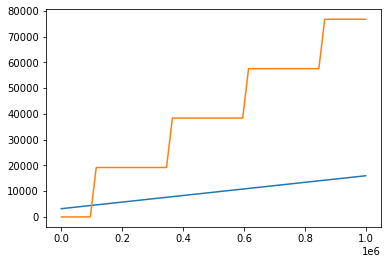

In [40]:
a_points = []
b_points = []
for i in range(0, 1_000_000, GRANULARITY):
    a_points.append(alpha_Pm(i, 2))
    b_points.append(beta_Pm(i, 2))

sns.lineplot(range(0, 1_000_000, GRANULARITY), a_points)
sns.lineplot(range(0, 1_000_000, GRANULARITY), b_points)

### Hop 2

In [41]:
GCL = [(70_000, 90_000, 7), 
       (115_000, 135_000, 6), 
       (130_000, 150_000, 5), 
       (145_000, 165_000, 4), 
       (85_000, 105_000, 3), 
       (155_000, 175_000, 2), 
       (100_000, 120_000, 1)]

In [42]:
tt_Pm[1] = 2
Pm_tt[2] = [1]
l_tt[1] = 3200
p_tt[1] = 250_000

## Number of window cases:
T_GCL = 250_000
for row in GCL:
    Pm = row[-1]
    N_Pm[Pm] = 1
    T_Pm[Pm] = 250_000
    
    t_Pm_o_i.setdefault(Pm, {})
    t_Pm_c_i.setdefault(Pm, {})
    t_Pm_o_i[Pm][0]= 0
    t_Pm_c_i[Pm][0]= 0
    for i in range(N_Pm[Pm]):
        t_Pm_o_i[Pm][i+1]= row[0] + i * T_Pm[Pm]
        t_Pm_c_i[Pm][i+1]= row[1] + i * T_Pm[Pm]
    l_max_Pm[Pm] = 400
    if Pm in Pm_tt:
        l_min_Pm[Pm] = min([l_tt[tt] for tt in Pm_tt[Pm]])
    else:
        l_min_Pm[Pm] = 0

In [52]:
L_Pm_i(2, 1)

19200

In [44]:
h(alpha_Pm, beta_Pm, 2)

159000

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

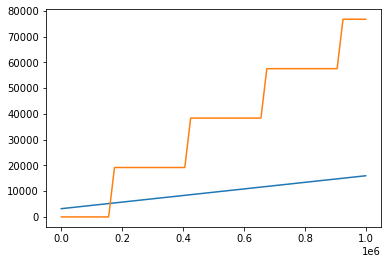

In [45]:
a_points = []
b_points = []
for i in range(0, 1_000_000, GRANULARITY):
    a_points.append(alpha_Pm(i, 2))
    b_points.append(beta_Pm(i, 2))

sns.lineplot(range(0, 1_000_000, GRANULARITY), a_points)
sns.lineplot(range(0, 1_000_000, GRANULARITY), b_points)

### Hop 3

In [46]:
GCL = [(170_000, 190_000, 5), 
       (180_000, 200_000, 2),  
       (140_000, 160_000, 1)]

In [47]:
tt_Pm[1] = 2
Pm_tt[2] = [1]
l_tt[1] = 3200
p_tt[1] = 250_000

## Number of window cases:
T_GCL = 250_000
for row in GCL:
    Pm = row[-1]
    N_Pm[Pm] = 1
    T_Pm[Pm] = 250_000
    
    t_Pm_o_i.setdefault(Pm, {})
    t_Pm_c_i.setdefault(Pm, {})
    t_Pm_o_i[Pm][0]= 0
    t_Pm_c_i[Pm][0]= 0
    for i in range(N_Pm[Pm]):
        t_Pm_o_i[Pm][i+1]= row[0] + i * T_Pm[Pm]
        t_Pm_c_i[Pm][i+1]= row[1] + i * T_Pm[Pm]
    l_max_Pm[Pm] = 400
    if Pm in Pm_tt:
        l_min_Pm[Pm] = min([l_tt[tt] for tt in Pm_tt[Pm]])
    else:
        l_min_Pm[Pm] = 0

In [48]:
L_Pm_i(2, 1)

19200

In [49]:
h(alpha_Pm, beta_Pm, 2)

184000

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

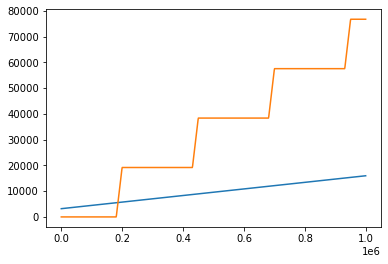

In [50]:
a_points = []
b_points = []
for i in range(0, 1_000_000, GRANULARITY):
    a_points.append(alpha_Pm(i, 2))
    b_points.append(beta_Pm(i, 2))

sns.lineplot(range(0, 1_000_000, GRANULARITY), a_points)
sns.lineplot(range(0, 1_000_000, GRANULARITY), b_points)

## Debug/